MNIST(Mixed National Institute of Standards and Technology) dataset which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.The dataset is divided into three sets - a training set with 50,000examples,a validation set with 10,000 examples and a test set with 10,000.It consists of 28 * 28 pixel images.Every single point(every image) can be conveyed as an array of numbers,where each number describes how dark each pixel is.In other words,a 28 * 28 array of numbers corresponds to a 28 * 28 pixel image.

fetch_mldata() is deprecated since scikit-learn 0.20.You should use fetch_openml() instead.However it returns the unsorted MNIST dataset,whereas fetch_mldata() returns the dataset sorted by target (the training and testing set were sorted separately)

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1,cache =True)
mnist.target = mnist.target.astype(np.int8)
#fetch_openml() returns target of strings
mnist["data"],mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X,y = mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

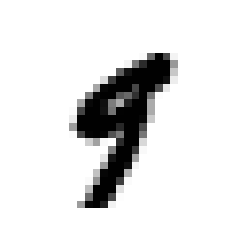

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation = "nearest")
plt.axis("off")
plt.show()

In [8]:
y[36000]

9

In [9]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#Shuffle the training set;that will guarantee all the cross-validation folds 
#will be similar(you don't want one fold to be missing from digits) 

In [15]:
#np.random.permutation(x)
#Randomly permuate a sequence,or return a permuted range
np.random.permutation(10)

array([9, 1, 5, 7, 2, 6, 3, 4, 8, 0])

In [16]:
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

Binary Classifier
Stochastic Gradient Classifier(SGD) has the advantage of being capable to handle very large datasets efficiently,as it deals with training instances independently,one at a time (Online learning)

In [17]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [18]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit])

array([False])

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_9,cv= 3,scoring = 'accuracy')

array([0.94   , 0.9224 , 0.94145])

In [21]:
#Cross-validation is actually fairly straightforward
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
#constructs a new estimator with the same parameters
#clone does a deep copy of the model in an estimator without 
#actually copying the original data.It yields a new estimator with the
#same parameters
skfolds = StratifiedKFold(n_splits = 3,random_state = 42)
for train_index,test_index in skfolds.split(X_train,y_train_9):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_9[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_9[test_index])
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
#StratifiedKFold performs stratified sampling to produce folds that contain 
#a representative ratis of each class,at each iteration it produces a clone of the
#classifier,that trains on the training folds and makes predictions on test fold

0.94
0.9224
0.94145


In [24]:
from sklearn.base import BaseEstimator
class Never9Classifer(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype = bool)

In [26]:
never_9_clf = Never9Classifer()
cross_val_score(never_9_clf,X_train,y_train_9,cv = 3,scoring="accuracy")

array([0.90375, 0.90065, 0.89815])

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_9,cv = 3)
confusion_matrix(y_train_9,y_train_pred)

array([[51401,  2650],
       [ 1273,  4676]], dtype=int64)

In [29]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_9,y_train_pred)

0.6382746382746383

In [30]:
recall_score(y_train_9,y_train_pred)

0.7860144562111279

In [31]:
y_train_perfect_predictions = y_train_9
confusion_matrix(y_train_9,y_train_perfect_predictions)

array([[54051,     0],
       [    0,  5949]], dtype=int64)

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_9,y_train_pred)

0.7044821092278719

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 10,random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_9,cv=3,
                                   method = "predict_proba")

In [34]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train,y_train_9,cv=3)
precision_score(y_train_9,y_train_pred_forest)

0.9729282909692085

In [35]:
recall_score(y_train_9,y_train_pred_forest)

0.7913935115145403

In [36]:
from sklearn.metrics import f1_score
f1_score(y_train_9,y_train_pred_forest)

0.8728216536892844